In [1]:
import numpy as np
from time import time
import healpy as hp
from multiprocessing import Pool
import tables
import sqlite3
import sys
import os
#from lsd import DB
#from lsd import bounds as lsdbounds
# various functions are defined here
import pmfuns

import calcMedianAndResiduals as ca
import pandas as pd
import matplotlib.pyplot as plt
import spherical_to_tangential as s2t
import random
import esutil
from esutil.numpy_util import match
from astropy.io import fits
from astropy.table import Table
import matplotlib
from esutil.coords import sphdist
#import math
#import calcMedianAndResiduals

In [2]:
nside = 2**24# pixelizes the sky
rootdir = "./data/" 

In [3]:
input_file = './data_per/hlsp_phat_hst_acs-wfc_12057-m31-b09-f01_f475w-f814w_v1_gst.fits'
hdu_list = fits.open(input_file, memmap=True)
evt_data = Table(hdu_list[1].data)
CRA = np.median(evt_data['RA'])
CDE = np.median(evt_data['DEC'])

In [4]:
table = pd.read_csv('./data/B9ComB11_2.0.csv')
chunkNo = 0
refDB = rootdir + "referenceGalDB%d"%chunkNo
ref_cri = (table['objid1'] != 0)

In [5]:
maskForGal = ref_cri#table.get_where_list(ref_cri)
    
#total number of *detections* of galaxies
noOfDetOfGal = 2*sum(maskForGal)
noOfGal = sum(maskForGal)

In [6]:
print(noOfDetOfGal,noOfGal)

(2542, 1271)


In [7]:
medianXiArray  = []
medianEtaArray = []
medianResidualXiArray  = []
medianResidualEtaArray = []
#store the residual values for each galaxy and for each epoch
residualXiArray  = []
residualEtaArray = []
    
    #store the number of observations for each galaxy 
noOfObsArray = []
    
    #store the objIDs of each galaxy -- we run it in the loop just for debugging purposes 
    #needs 64-bit unsigned integer datatype
objIDarray = []
objID = 0
ra1Objs, dec1Objs, status = s2t.ds2tp(table['ra1'], table['dec1'], CRA, CDE)
ra2Objs, dec2Objs, status = s2t.ds2tp(table['ra2'], table['dec2'], CRA, CDE)

In [8]:
for j in range(noOfDetOfGal):
    if j < len(table['objid1']):
        if table['objid1'][j] == table['objid2'][j]:
            medianXi = np.median([ra1Objs[j],ra2Objs[j]])
            medianEta = np.median([dec1Objs[j],dec2Objs[j]])
            medianXiArray.append(medianXi)
            medianEtaArray.append(medianEta)
            residual1Xi = ra1Objs[j] - medianXi
            residual2Xi = ra2Objs[j] - medianXi
            residual1Eta = dec1Objs[j] - medianEta
            residual2Eta = dec2Objs[j] - medianEta
            residualXiArray.append(residual1Xi)
            residualXiArray.append(residual2Xi)
            residualEtaArray.append(residual1Eta)
            residualEtaArray.append(residual2Eta)
            medianResidualXi = np.median([residual1Xi,residual2Xi])
            medianResidualEta = np.median([residual1Eta,residual2Eta])
            medianResidualXiArray.append(medianResidualXi)
            medianResidualEtaArray.append(medianResidualEta)
            noOfObsArray.append(2)
            objID += 1
            objIDarray.append(objID)

In [9]:
medianRaArray, medianDecArray = s2t.dtp2s(np.radians(medianXiArray), np.radians(medianEtaArray), CRA, CDE) # output in degree

In [ ]:
table = pd.read_csv('./data/B9ComB11_gal3.0.csv')
ref_cri1 = (table['objid'] != 0)

In [10]:
print(medianRaArray)

[11.192396  11.1982225 11.1998535 ... 11.1824225 11.1990065 11.1949315]


In [12]:
table = pd.read_csv('./data/B9ComB11_gal3.0.csv')
ref_cri1 = (table['objid'] != 0)

In [13]:
maskForGal = ref_cri1 #already defined in calcmed..func
mjdValues  = table['mjd'][maskForGal]
mjdSorted  = np.sort(mjdValues)
deltaT = mjdSorted[0:-1] - mjdSorted[1:]
tBreakAt   = np.where(deltaT < (-100.0))[0]
mjdBreakAt = mjdSorted[tBreakAt+1]

In [14]:
# objIDs and MJDs that match the residual rows (need this for the pixelTasks function)
objIDs = table['obj_id'][maskForGal] #already defined in calcmed..func
MJDs   = table['mjd'][maskForGal]
#store ra/dec values of all galaxies, to be passed to each pixel later
raGal  = table['ra'][maskForGal]
decGal = table['dec'][maskForGal]

# store min and max values separately
minRaGal  = table['ra'][maskForGal].min()
maxRaGal  = table['ra'][maskForGal].max()
minDecGal = table['dec'][maskForGal].min()
maxDecGal = table['dec'][maskForGal].max()
#print "minRaGal, and maxRaGal", minRaGal, maxRaGal
#print "minDecGal, and maxDecGal", minDecGal, maxDecGal
#degree2rad
phiForObj   = (medianRaArray*np.pi)/180 
thetaForObj = (90 - medianDecArray)* (np.pi/180) 
print thetaForObj, phiForObj
pixelIndexForObj = hp.ang2pix(nside, thetaForObj, phiForObj) 

[0.84450068 0.84464839 0.84475201 ... 0.84412116 0.84470882 0.84458009] [0.19534416 0.19544585 0.19547432 ... 0.19517009 0.19545954 0.19538841]


In [15]:
# consider only pixels in the region where we have data while taking into account the 10 arcmin buffer
goodPixels = ref_cri
pixelIndexArray = np.unique(pixelIndexForObj[goodPixels])
theta, phi = hp.pix2ang(nside, pixelIndexArray)
pixelRa  = 180*phi/np.pi
pixelDec = 90 - theta*180/np.pi

In [16]:
print(len(pixelIndexArray))

1271


In [17]:
print "galaxy number %d in this chunk." % len(objIDarray)
print "galaxy observatinal times %d:" % len(objIDs)
print "Going to process %d pixels." % pixelIndexArray.size

galaxy number 1271 in this chunk.
galaxy observatinal times 2542:
Going to process 1271 pixels.


In [18]:
gnomonic = True
parameterListForPixel = [(pickPixelNo, pixelRa[i], pixelDec[i], np.array(objIDarray), medianRaArray, medianDecArray, objIDs, \
MJDs, np.array(residualXiArray), np.array(residualEtaArray), raGal, decGal, pixelIndexForObj, mjdBreakAt, gnomonic, CRA, CDE) for i, \
pickPixelNo in enumerate(pixelIndexArray)]
pmfuns.referenceGals(parameterListForPixel, refDB)

(array([158]), array([11.1890045]), array([41.6011175]), array([5.90215069e-06]), array([6.96602722e-06]))
objID in the pixel: [158]
(array([1102]), array([11.2079145]), array([41.6010905]), array([2.43113995e-06]), array([5.10765168e-06]))
objID in the pixel: [1102]
(array([159]), array([11.1897225]), array([41.601056]), array([2.43044064e-06]), array([1.85769336e-06]))
objID in the pixel: [159]
(array([1133]), array([11.206665]), array([41.6009635]), array([3.47233307e-06]), array([4.64632517e-07]))
objID in the pixel: [1133]
(array([1219]), array([11.202236]), array([41.6008395]), array([2.08338561e-06]), array([1.39311969e-06]))
objID in the pixel: [1219]
(array([170]), array([11.1876495]), array([41.600759]), array([1.04171446e-06]), array([1.45673454e-10]))
objID in the pixel: [170]
(array([160]), array([11.189111]), array([41.6006485]), array([3.47198777e-06]), array([3.25089752e-06]))
objID in the pixel: [160]
(array([1197]), array([11.2042135]), array([41.600546]), array([1.04

(array([981]), array([11.196182]), array([41.6401175]), array([9.02270203e-06]), array([4.63983001e-07]))
objID in the pixel: [981]
(array([943]), array([11.197992]), array([41.640118]), array([6.93996801e-07]), array([2.78613144e-06]))
objID in the pixel: [943]
(array([377]), array([11.2251705]), array([41.640079]), array([1.04080545e-06]), array([9.29013164e-07]))
objID in the pixel: [377]
(array([357]), array([11.2255525]), array([41.639985]), array([1.04080286e-06]), array([9.29017779e-07]))
objID in the pixel: [357]
(array([281]), array([11.2319085]), array([41.6398985]), array([2.43075203e-06]), array([4.17826956e-06]))
objID in the pixel: [281]
(array([738]), array([11.2068845]), array([41.6398635]), array([3.47143385e-07]), array([1.39302994e-06]))
objID in the pixel: [738]
(array([369]), array([11.2257845]), array([41.639836]), array([1.73570035e-06]), array([1.8568872e-06]))
objID in the pixel: [369]
(array([428]), array([11.22341]), array([41.639831]), array([3.46951305e-06]

(array([704]), array([11.2120305]), array([41.633368]), array([1.73544561e-06]), array([9.28458049e-07]))
objID in the pixel: [704]
(array([1037]), array([11.197542]), array([41.633352]), array([6.941488e-07]), array([9.28688294e-07]))
objID in the pixel: [1037]
(array([314]), array([11.23145]), array([41.6333465]), array([4.86007435e-06]), array([3.24868255e-06]))
objID in the pixel: [314]
(array([578]), array([11.218961]), array([41.6333115]), array([2.77681414e-06]), array([1.39243918e-06]))
objID in the pixel: [578]
(array([47]), array([11.1797605]), array([41.633163]), array([5.20638555e-06]), array([1.85620693e-06]))
objID in the pixel: [47]
(array([1139]), array([11.190179]), array([41.6330795]), array([1.38804611e-05]), array([1.90400044e-05]))
objID in the pixel: [1139]
(array([112]), array([11.175516]), array([41.6330375]), array([3.47051375e-06]), array([4.65326843e-07]))
objID in the pixel: [112]
(array([6]), array([11.1830715]), array([41.6330355]), array([2.42971965e-06])

(array([189]), array([11.160598]), array([41.6292925]), array([4.85855259e-06]), array([1.39526267e-06]))
objID in the pixel: [189]
(array([774]), array([11.210622]), array([41.6292515]), array([6.94345642e-07]), array([1.39297091e-06]))
objID in the pixel: [774]
(array([834]), array([11.20818]), array([41.6292445]), array([1.388567e-06]), array([2.32162824e-06]))
objID in the pixel: [834]
(array([573]), array([11.221557]), array([41.62922]), array([2.08321511e-06]), array([2.78559005e-06]))
objID in the pixel: [573]
(array([874]), array([11.2069095]), array([41.6291815]), array([1.73561929e-06]), array([2.32161975e-06]))
objID in the pixel: [874]
(array([1169]), array([11.1905895]), array([41.629164]), array([1.73552446e-06]), array([9.28522125e-07]))
objID in the pixel: [1169]
(array([684]), array([11.214414]), array([41.6291375]), array([1.38857889e-06]), array([1.39282212e-06]))
objID in the pixel: [684]
(array([1173]), array([11.190217]), array([41.629105]), array([4.16533352e-06]

objID in the pixel: [57]
(array([389]), array([11.2375105]), array([41.6144375]), array([3.48181817e-07]), array([2.32161248e-06]))
objID in the pixel: [389]
(array([723]), array([11.2208185]), array([41.614407]), array([3.46937506e-07]), array([9.28790719e-07]))
objID in the pixel: [723]
(array([414]), array([11.236585]), array([41.6143945]), array([6.9333724e-07]), array([2.32206127e-06]))
objID in the pixel: [414]
(array([507]), array([11.232439]), array([41.6143855]), array([2.77573329e-06]), array([4.18022955e-06]))
objID in the pixel: [507]
(array([144]), array([11.1838185]), array([41.614318]), array([2.43015615e-06]), array([4.47839394e-10]))
objID in the pixel: [144]
(array([795]), array([11.218357]), array([41.6143045]), array([1.38956404e-06]), array([4.17887611e-06]))
objID in the pixel: [795]
(array([959]), array([11.209797]), array([41.6142545]), array([6.24903326e-06]), array([4.63622821e-07]))
objID in the pixel: [959]
(array([90]), array([11.1890955]), array([41.614246

(array([219]), array([11.1775375]), array([41.610687]), array([1.21502712e-05]), array([4.64665291e-06]))
objID in the pixel: [219]
(array([256]), array([11.180555]), array([41.6106205]), array([2.08300728e-06]), array([4.64815557e-07]))
objID in the pixel: [256]
(array([77]), array([11.189184]), array([41.610605]), array([9.72084388e-06]), array([2.78730427e-06]))
objID in the pixel: [77]
(array([609]), array([11.229218]), array([41.610567]), array([1.38810627e-06]), array([1.8578865e-06]))
objID in the pixel: [609]
(array([1101]), array([11.2029475]), array([41.6105415]), array([3.47202873e-07]), array([4.64339916e-07]))
objID in the pixel: [1101]
(array([1157]), array([11.2007905]), array([41.6105205]), array([1.04157412e-06]), array([1.39304578e-06]))
objID in the pixel: [1157]
(array([266]), array([11.177961]), array([41.6105065]), array([1.3883914e-06]), array([1.39340893e-06]))
objID in the pixel: [266]
(array([1056]), array([11.2060345]), array([41.6104975]), array([2.18722585e

objID in the pixel: [126]
(array([2]), array([11.1982225]), array([41.605212]), array([3.47214175e-07]), array([6.01470486e-12]))
objID in the pixel: [2]
(array([1084]), array([11.206341]), array([41.605186]), array([6.94499946e-07]), array([9.28652573e-07]))
objID in the pixel: [1084]
(array([259]), array([11.1815555]), array([41.6051645]), array([1.73558336e-06]), array([2.3221301e-06]))
objID in the pixel: [259]
(array([98]), array([11.1913275]), array([41.605106]), array([5.20795023e-06]), array([2.78662402e-06]))
objID in the pixel: [98]
(array([1144]), array([11.2056825]), array([41.605035]), array([3.47215129e-07]), array([2.40011794e-11]))
objID in the pixel: [1144]
(array([69]), array([11.192399]), array([41.6050245]), array([6.94418553e-06]), array([1.39364778e-06]))
objID in the pixel: [69]
(array([1265]), array([11.1975245]), array([41.6050045]), array([3.1248786e-06]), array([2.3218441e-06]))
objID in the pixel: [1265]
(array([46]), array([11.1938805]), array([41.6049935])

(array([728]), array([11.215669]), array([41.624793]), array([6.94732779e-07]), array([2.78598895e-06]))
objID in the pixel: [728]
(array([944]), array([11.207225]), array([41.624761]), array([6.24844589e-06]), array([5.57169085e-06]))
objID in the pixel: [944]
(array([1131]), array([11.1951495]), array([41.6247545]), array([2.42959068e-06]), array([3.25059889e-06]))
objID in the pixel: [1131]
(array([920]), array([11.206759]), array([41.624691]), array([1.38805819e-06]), array([4.64364223e-06]))
objID in the pixel: [920]
(array([868]), array([11.2108085]), array([41.6246545]), array([1.04174649e-06]), array([3.25033632e-06]))
objID in the pixel: [868]
(array([778]), array([11.213356]), array([41.624608]), array([9.02544131e-06]), array([3.71339614e-06]))
objID in the pixel: [778]
(array([27]), array([11.1856775]), array([41.624598]), array([3.47714468e-07]), array([3.71476662e-06]))
objID in the pixel: [27]
(array([1103]), array([11.195966]), array([41.6245885]), array([5.55361649e-06

objID in the pixel: [783]
(array([1134]), array([11.196613]), array([41.620598]), array([3.47131348e-06]), array([1.24923442e-10]))
objID in the pixel: [1134]
(array([730]), array([11.217462]), array([41.6205875]), array([1.38804804e-06]), array([2.32205008e-06]))
objID in the pixel: [730]
(array([210]), array([11.1652895]), array([41.620572]), array([3.81844683e-06]), array([1.52394737e-09]))
objID in the pixel: [210]
(array([760]), array([11.2163115]), array([41.620564]), array([3.47667525e-07]), array([2.78605057e-06]))
objID in the pixel: [760]
(array([515]), array([11.228895]), array([41.620543]), array([6.94891633e-07]), array([1.85717676e-06]))
objID in the pixel: [515]
(array([1088]), array([11.199357]), array([41.6205255]), array([6.9426173e-06]), array([4.17920501e-06]))
objID in the pixel: [1088]
(array([197]), array([11.1753975]), array([41.6204835]), array([2.42979297e-06]), array([4.65037952e-07]))
objID in the pixel: [197]
(array([301]), array([11.239978]), array([41.620

objID in the pixel: [692]
(array([411]), array([11.2353855]), array([41.616367]), array([4.51185214e-06]), array([2.78798331e-06]))
objID in the pixel: [411]
(array([234]), array([11.171554]), array([41.6163595]), array([2.08277355e-06]), array([4.65032878e-07]))
objID in the pixel: [234]
(array([1217]), array([11.1954715]), array([41.6163575]), array([1.73574802e-06]), array([4.64438321e-07]))
objID in the pixel: [1217]
(array([338]), array([11.239205]), array([41.616237]), array([2.7759636e-06]), array([2.78738864e-06]))
objID in the pixel: [338]
(array([1038]), array([11.2048755]), array([41.616205]), array([6.59594495e-06]), array([3.94366066e-10]))
objID in the pixel: [1038]
(array([1199]), array([11.1957535]), array([41.616187]), array([3.47069738e-07]), array([1.85742754e-06]))
objID in the pixel: [1199]
(array([392]), array([11.2361925]), array([41.61617]), array([3.81713671e-06]), array([3.71643779e-06]))
objID in the pixel: [392]
(array([347]), array([11.2389485]), array([41.

objID in the pixel: [740]
(array([932]), array([11.1926035]), array([41.6504565]), array([2.42875599e-06]), array([4.64553408e-07]))
objID in the pixel: [932]
(array([409]), array([11.21799]), array([41.650432]), array([4.16305886e-06]), array([2.78700043e-06]))
objID in the pixel: [409]
(array([596]), array([11.209275]), array([41.6504155]), array([2.77581813e-06]), array([4.64045265e-07]))
objID in the pixel: [596]
(array([405]), array([11.2188535]), array([41.6503865]), array([3.12098775e-06]), array([7.89469399e-06]))
objID in the pixel: [405]
(array([591]), array([11.2100085]), array([41.650334]), array([1.04113542e-06]), array([1.85728771e-06]))
objID in the pixel: [591]
(array([641]), array([11.206525]), array([41.65033]), array([2.77621011e-06]), array([5.57201669e-06]))
objID in the pixel: [641]
(array([910]), array([11.1936645]), array([41.6502795]), array([3.46743473e-07]), array([3.25049528e-06]))
objID in the pixel: [910]
(array([315]), array([11.2229695]), array([41.65023

objID in the pixel: [951]
(array([286]), array([11.2296585]), array([41.6434015]), array([3.47492166e-07]), array([1.39293836e-06]))
objID in the pixel: [286]
(array([700]), array([11.206726]), array([41.6432935]), array([3.77291763e-11]), array([4.64352938e-07]))
objID in the pixel: [700]
(array([752]), array([11.2048035]), array([41.6432295]), array([1.73496544e-06]), array([1.39316117e-06]))
objID in the pixel: [752]
(array([278]), array([11.2299265]), array([41.643147]), array([1.03940374e-06]), array([4.64389422e-06]))
objID in the pixel: [278]
(array([914]), array([11.198979]), array([41.643114]), array([2.08205844e-05]), array([2.78629595e-06]))
objID in the pixel: [914]
(array([737]), array([11.2056455]), array([41.643081]), array([1.04122243e-06]), array([2.78604608e-06]))
objID in the pixel: [737]
(array([332]), array([11.225902]), array([41.643083]), array([1.38832323e-06]), array([9.28284382e-07]))
objID in the pixel: [332]
(array([1206]), array([11.1815515]), array([41.643

In [18]:
objIDarray, finalRaArray, finalDecArray, medianRaError, medianDecError = pmfuns.readDB(refDB)

In [22]:
print(finalRaArray)

[11.1890045 11.2079145 11.1897225 ... 11.19678   11.204201  11.226897 ]


In [20]:
NGAL = 600
for i, pickPixelNo in enumerate(pixelIndexArray):
    pixelNo = pickPixelNo
    pixRa = pixelRa[i]
    pixDec = pixelDec[i]
    objID = np.array(objIDarray)
    medRa = medianRaArray
    medDec = medianDecArray
    objIDs = objIDs
    MJDs = MJDs
    resRa = np.array(residualXiArray)
    resDec = np.array(residualEtaArray)
    raAll = raGal
    decAll = decGal
    pixAll = pixelIndexForObj
    mjdBreakAt = mjdBreakAt
    ra0 = CRA
    dec0 = CDE
    distTmp = sphdist(pixRa, pixDec, medRa, medDec)
    angSepMask = (distTmp) <= (60.0/60.0)
    if(sum(angSepMask)>600):
        angSepMask = np.argsort(distTmp)
        angSepMask = angSepMask[0:NGAL]
    elif(sum(angSepMask)<100):
        angSepMask = np.argsort(distTmp)
        angSepMask = angSepMask[0:100]

    angSepMask = np.argsort(distTmp)
    angSepMask = angSepMask[0:NGAL]

    objInRadius = objID[angSepMask]
    #print "galaxy number in the circle:",len(objInRadius) 
    #print "min(decAll), max(decAll):", min(decAll), max(decAll)

    '''we use PANDAS'''
    try:
        flag1 = 1 
	r1 = time()
	temp = pd.Index(objIDs)
	inde = temp.get_indexer_for(objInRadius)
	#print 'Test1:',max(inde), len(inde)
	inde = inde[inde > -1]
	#print 'Test2:',len(inde)
	inde = np.array(inde, dtype='i8')
	#print 'Test3:',resRa
	#print 'Test3:',len(resRa), max(inde)
	resRaValuesInRadius = resRa[inde]
	#print 'Test4:',resRaValuesInRadius
	resDecValuesInRadius = resDec[inde]
	mjdInRadius = MJDs[inde]
	#print 'galaxy mjdInRadius:',mjdInRadius
	    
    except IndexError:
	#print 'galaxy mjdInRadius:',mjdInRadius
        print pixelNo, flag1, inde.size
	    
    #for storing median values for each epoch
    medianResidualRaEpochWise  = np.zeros(len(mjdBreakAt)+1)
    medianResidualDecEpochWise = np.zeros(len(mjdBreakAt)+1)
    indexInPixel = pixAll == pixelNo
    objIDinPixel = objID[indexInPixel]
   
    try :
	    flag2 = 2 
	    temp2 = pd.Index(objIDs)
	    inde2 = temp2.get_indexer_for(objIDinPixel)
	    inde2 = inde2[inde2 > -1]
	    inde2 = np.array(inde2, dtype='i8')
	    raInPixel = raAll[inde2]
	    decInPixel = decAll[inde2]
	    #########################(RA, DEC) ==> (xi, eta)#################################
	    if(gnomonic):
	        raInPixel, decInPixel, status = s2t.ds2tp(raInPixel, decInPixel, ra0, dec0)# transform the (RA, DEC)/degree into (xi, eta)/degree
	        #print "Number points in bad transformation:", np.sum(status)
	    #################################################################################
	    objInPixel = objIDs[inde2]
	    mjdInPixel = MJDs[inde2]
	    #print "time taken for pandas indexer", time() - r1
    except IndexError:
        print pixelNo, flag2, inde2.size
	    #return pixelNo, flag2, inde2.size
    
    #if there are atleast three epochs present
    #print(len(mjdBreakAt))
    if (len(mjdBreakAt)>=1.0):
	for mjdIdx in range(0, len(mjdBreakAt)+1):
	    if(mjdIdx==0):
	        var = mjdBreakAt[mjdIdx]
		mjdIndexInPixel = mjdInPixel < var
		mjdIndex = mjdInRadius < var
	    elif(mjdIdx==len(mjdBreakAt)):
	        var = mjdBreakAt[mjdIdx-1]
		mjdIndexInPixel = mjdInPixel >= var
		mjdIndex = mjdInRadius >= var
	    else:
	        var = mjdBreakAt[mjdIdx]
		mjdIndex = (mjdInRadius >= mjdBreakAt[mjdIdx-1]) & (mjdInRadius < var)
                mjdIndexInPixel = (mjdInPixel >= mjdBreakAt[mjdIdx-1]) & (mjdInPixel < var)

            if(any(mjdIndex)):
                resRaValues  = resRaValuesInRadius[mjdIndex]
                resDecValues = resDecValuesInRadius[mjdIndex]
		#print "number in resRaValues:", len(resRaValues)
                assert(resRaValues.size > 0.0), "resRaValues is empty"
                assert(resDecValues.size > 0.0), "resDecValues is empty"
                medianResidualRaEpochWise[mjdIdx]  = np.median(resRaValues)
                medianResidualDecEpochWise[mjdIdx] = np.median(resDecValues)
		#print "np.median(resRaValues):", np.median(resRaValues)
                raInPixel[mjdIndexInPixel] -=  medianResidualRaEpochWise[mjdIdx]
                decInPixel[mjdIndexInPixel] -=  medianResidualDecEpochWise[mjdIdx]

    #calculate final ra/dec as the median of newRa/newDec values
    finalRaArray  = np.zeros(objIDinPixel.size)
    finalDecArray = np.zeros(objIDinPixel.size)
    medianRaError  = np.zeros(objIDinPixel.size)
    medianDecError = np.zeros(objIDinPixel.size)
    
    objInPixel = np.array(objInPixel)
    raInPixel = np.array(raInPixel)
    decInPixel = np.array(decInPixel)
    mjdInPixel = np.array(mjdInPixel)
    #print "galaxy number in the pixel:", len(finalRaArray)
    try:
        #take the current values separately
        obj   = objInPixel[0]
        #print(type(raInPixel))
        raObj = [raInPixel[0]]
        decObj = [decInPixel[0]]
        mjdObj = [mjdInPixel[0]]
        #set variables
        counter = 0
        pos2 = 0
        t2   = time()
        for i in np.arange(objInPixel.size-1)+1:#np.arange(10)+1: #
            #print 'on the row number',i
            objID = objInPixel[i]
            ra  = raInPixel[i]
            dec = decInPixel[i]
            if(objID == obj):
                raObj.append(ra)
                decObj.append(dec)
            else:
                raObj = np.array(raObj)
                decObj= np.array(decObj)

                finalRaArray[counter]  = np.median(raObj)
                finalDecArray[counter] = np.median(decObj)
                #calculate rms values for ra/dec
                rmsRa  = 0.741*(np.percentile(raObj, 75) - np.percentile(raObj, 25))
                rmsDec = 0.741*(np.percentile(decObj, 75) - np.percentile(decObj, 25))
                #calculate uncertainity in median coordinates
                medianRaError[counter]  = np.sqrt((np.pi/2)/(raObj.size-1))*rmsRa
                medianDecError[counter] = np.sqrt((np.pi/2)/(decObj.size-1))*rmsDec
                obj  = objID
                pos2 = i
                counter +=1
                #make them lists again
                raObj  =[raInPixel[i]]
                decObj =[decInPixel[i]]
        #processing the last object now
        raObj  = np.array(raObj)
        decObj = np.array(decObj)
        finalRaArray[counter]  = np.median(raObj)
        finalDecArray[counter] = np.median(decObj)
        #calculate rms values for ra/dec
        rmsRa  = 0.741*(np.percentile(raObj, 75) - np.percentile(raObj, 25))
        rmsDec = 0.741*(np.percentile(decObj, 75) - np.percentile(decObj, 25))
        medianRaError[counter]  = np.sqrt((np.pi/2)/(raObj.size-1))*rmsRa
        medianDecError[counter] = np.sqrt((np.pi/2)/(decObj.size-1))*rmsDec
	#########################(xi, eta) ==> (RA, DEC)#################################
	if(gnomonic): # transform the (xi, eta)/radians into (RA, DEC)/degree
	    finalRaArray, finalDecArray = s2t.dtp2s(np.radians(finalRaArray), np.radians(finalDecArray), ra0, dec0)
    except IndexError:
        #pass
        print "index error"

In [52]:
finalRaArray = np.array(finalRaArray)
print(finalRaArray)

[11.1881615]


In [11]:
#calculate medians and residual
table_medianRA = np.median(table['ra'])
table_medianDEC = np.median(table['dec'])
table2_medianRA = np.median(table2['ra'])
table2_medianDEC = np.median(table2['dec'])

table_residualRA = []
table_residualDEC = []
table2_residualRA = []
table2_residualDEC = []


for i in range(len(table)):
    table_residualRA.append(table['ra'][i]-table_medianRA)
    table_residualDEC.append(table['dec'][i]-table_medianDEC)

    
for j in range(len(table2)):
    table2_residualRA.append(table2['ra'][j]-table2_medianRA)
    table2_residualDEC.append(table2['dec'][j]-table2_medianDEC)
#print(table2_residualRA)
#print(residualRAArray2)


In [5]:
x = table['ra']
y = table['dec']

X = np.array(x)
Y = np.array(y)
#print(len(X),len(Y),len(medianDECArray))
x2 = table2['ra']
y2 = table2['dec']

X2 = np.array(x2)
Y2= np.array(y2)

x3 = table3['ra']
y3 = table3['dec']

X3 = np.array(x3)
Y3 = np.array(y3)

/home/njl/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


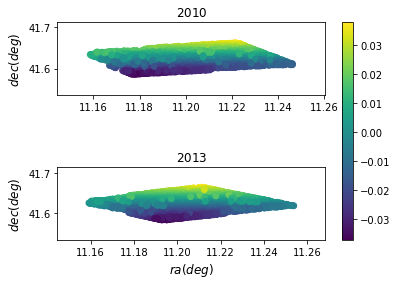

In [6]:
#plot figure2

fig, ax =plt.subplots(2,1)
plt.subplots_adjust(wspace=0.5, hspace=1.0)
ax = ax.flatten()

ax0 = ax[0].scatter(X,Y,c=residualDecArray)
ax1 = ax[1].scatter(X2,Y2,c=residualDecArray2)
#ax2 = ax[2].scatter(X3,Y3,c=residualDecArray3)
fig.colorbar(ax0, ax=[ax[0],ax[1]])
#plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.xlabel(r'$ra(deg)$',fontsize=12)
ax[0].set_ylabel(r'$dec(deg)$',fontsize=12)
ax[1].set_ylabel(r'$dec(deg)$',fontsize=12)
#ax[2].set_ylabel(r'$dec(deg)$',fontsize=12)
ax[0].set_title(r'$2010$',fontsize=12)
ax[1].set_title(r'$2013$',fontsize=12)
#ax[2].set_title(r'$com$',fontsize=12)

fig.show()

Text(0.5,1,'2010')

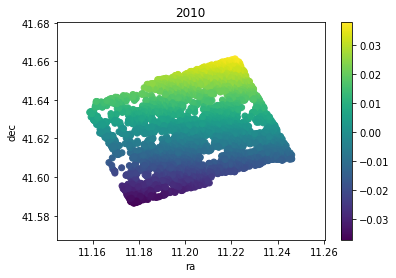

In [23]:
#plot figure2
fig = plt.figure()

plt.scatter(X, Y, c=residualDecArray)
plt.colorbar()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('2010')

Text(0.5,1,'2013')

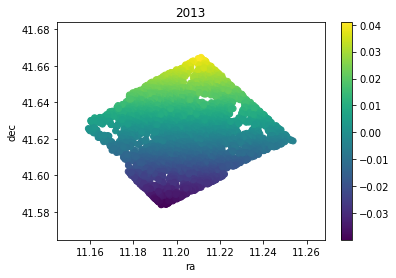

In [24]:
fig = plt.figure()

plt.scatter(X2, Y2, c=residualDecArray2)
plt.colorbar()
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('2013')